In [1]:
import os
import sys
sys.path.append("../") # go to parent dir
import glob
import time
import logging
import numpy as np
from scipy.sparse import linalg as spla
import matplotlib.pyplot as plt
import logging
from mpl_toolkits import mplot3d
from dedalus.tools.config import config
from simple_sphere import SimpleSphere, TensorField, TensorSystem
import equations
import pickle as pkl
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

#add path to data folder
input_folder = "/Volumes/ExtDrive/data"
output_folder = "plots"
dpi=300

first_frame = 1
last_frame = 1000

lmid4_Om250 = ['sphere%i' %(i) for i in range(141, 150+1)]
lmid4_Om500 = ['sphere%i' %(i) for i in range(130, 139+1)]
lmid8_Om500 = ['sphere%i' %(i) for i in range(120, 129+1)]

sphere_lists = [None]*3

sphere_lists[0] = [['sphere113'], ['sphere114'], ['sphere115']]
sphere_lists[1] = [['sphere111'], lmid4_Om250, lmid4_Om500]
sphere_lists[2] = [['sphere116'], ['sphere117'], lmid8_Om500]

#fs = ["%s/%s" %(input_folder, sphere_list[i]) for i in range(len(sphere_list))]

In [2]:
#get gammas from Lmid and kappa setting R=1 and tau=1
def get_gammas(Lmid, kappa):
    
    a = 0.25*(Lmid**2*kappa**2 - 0.5*(2*np.pi*Lmid+1)**2)**2 + 17*17/16 - (34/16)*(2*np.pi*Lmid+1)**2
    b = (17/4 - 0.25*(2*np.pi*Lmid+1)**2)**2
    c = 1/(17/4 - 0.25*(2*np.pi*Lmid + 1)**2 - 2)
    gamma0 = a*c/(a-b)
    gamma2 = -2*np.sqrt(b)*c/(a-b)
    gamma4 = c/(a-b)
    
    return [gamma0, gamma2, gamma4]

#define function that returns the neutral ell's for a given R/Lambda and kappa
def get_l(Lmid, kappa):
    
    gamma0, gamma2, gamma4 = get_gammas(Lmid, kappa)
    delta_p = (0.5/gamma4)*(-gamma2+np.sqrt(gamma2**2-4*gamma0*gamma4))
    delta_m = (0.5/gamma4)*(-gamma2-np.sqrt(gamma2**2-4*gamma0*gamma4))
    
    l_p = 0.5*(-1+np.sqrt(17+4*delta_p))
    l_m = 0.5*(-1+np.sqrt(17+4*delta_m))
        
    return l_m, l_p  

In [27]:
#t_arr = np.zeros(last_frame - first_frame + 1)

#create tensor objects 
L_max = 255
S_max = 4
simplesphere = SimpleSphere(L_max, S_max)
omega = TensorField(simplesphere, rank=0)

om_coeffs = np.zeros((last_frame-first_frame+1, 256, 256), dtype=complex)
om = np.zeros((512, 256))

# load omega data
for i, str in enumerate(fs):
    
    for j, ind in enumerate(range(first_frame, last_frame+1, 1)):
        
        with np.load("%s/output_%i.npz" %(fs[i], ind)) as file:
            if ind%100==0: print("Loaded %s/output_%i.npz" %(fs[i], ind))
            
            om = file['om']
            phi = file['phi']
            theta = file['theta']
            #t_arr[j] = file['t'][0]
            
        # assign loaded data
        omega.component_fields[0]['g'] = om
        # spectral transform
        omega.forward_phi()
        omega.forward_theta()
        for m in range(len(omega.coeffs)):
            om_coeffs[j, m, m:] = omega.coeffs[m]
            
    save_dict = {'t': t_arr, 'om_coeffs': om_coeffs}
    with open('../data/%s.pkl' %(sphere_list[i]), 'wb') as file:
        pkl.dump(save_dict, file, protocol=pkl.HIGHEST_PROTOCOL)
        
    print('\nSAVED!!!!\n')   

Loaded /Volumes/ExtDrive/data/sphere130/output_100.npz
Loaded /Volumes/ExtDrive/data/sphere130/output_200.npz
Loaded /Volumes/ExtDrive/data/sphere130/output_300.npz
Loaded /Volumes/ExtDrive/data/sphere130/output_400.npz
Loaded /Volumes/ExtDrive/data/sphere130/output_500.npz
Loaded /Volumes/ExtDrive/data/sphere130/output_600.npz
Loaded /Volumes/ExtDrive/data/sphere130/output_700.npz
Loaded /Volumes/ExtDrive/data/sphere130/output_800.npz
Loaded /Volumes/ExtDrive/data/sphere130/output_900.npz
Loaded /Volumes/ExtDrive/data/sphere130/output_1000.npz

SAVED!!!!

Loaded /Volumes/ExtDrive/data/sphere131/output_100.npz
Loaded /Volumes/ExtDrive/data/sphere131/output_200.npz
Loaded /Volumes/ExtDrive/data/sphere131/output_300.npz
Loaded /Volumes/ExtDrive/data/sphere131/output_400.npz
Loaded /Volumes/ExtDrive/data/sphere131/output_500.npz
Loaded /Volumes/ExtDrive/data/sphere131/output_600.npz
Loaded /Volumes/ExtDrive/data/sphere131/output_700.npz
Loaded /Volumes/ExtDrive/data/sphere131/output_800.n

In [3]:
L_max = 255
om_coeffs_list = [[[] for i in range(3)] for j in range(3)] 

for i in range(3):
    for j in range(3):
        for str in sphere_lists[i][j]:
            print(str)
            with open('../data/%s.pkl' %(str), 'rb') as file:
                save_dict = pkl.load(file)
                t_arr = save_dict['t']
                om_coeffs_list[i][j].append(save_dict['om_coeffs'])
            

sphere113
sphere114
sphere115
sphere111
sphere141
sphere142
sphere143
sphere144
sphere145
sphere146
sphere147
sphere148
sphere149
sphere150
sphere130
sphere131
sphere132
sphere133
sphere134
sphere135
sphere136
sphere137
sphere138
sphere139
sphere116
sphere117
sphere120
sphere121
sphere122
sphere123
sphere124
sphere125
sphere126
sphere127
sphere128
sphere129


In [4]:
ell = np.arange(1,256, dtype='float64')
m = np.arange(0,256, dtype='float64')
ellell, mm = np.meshgrid(ell, m)

E_ell = [[np.zeros_like(ell, dtype='float64') for i in range(3)] for j in range(3)]

for i in range(3):
    for j in range(3):
        
        om_av = np.zeros_like(ellell, dtype='float64')
        
        if len(sphere_lists[i][j])==1:
            ind_thresh = 1500
        else:
            ind_thresh = 300

        for count, str in enumerate(sphere_lists[i][j]):
            print(str)
            om_coeffs = om_coeffs_list[i][j][count][ind_thresh:, :, 1:]
            om_av += np.mean(np.abs(om_coeffs)**2, axis=0) / (ellell*(ellell+1))

        om_av = om_av / len(sphere_lists[i][j])
        E_ell[i][j] = np.sum(om_av, axis=0)


sphere113
sphere114
sphere115
sphere111
sphere141
sphere142
sphere143
sphere144
sphere145
sphere146
sphere147
sphere148
sphere149
sphere150
sphere130
sphere131
sphere132
sphere133
sphere134
sphere135
sphere136
sphere137
sphere138
sphere139
sphere116
sphere117
sphere120
sphere121
sphere122
sphere123
sphere124
sphere125
sphere126
sphere127
sphere128
sphere129


//anaconda3/envs/dedalus/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


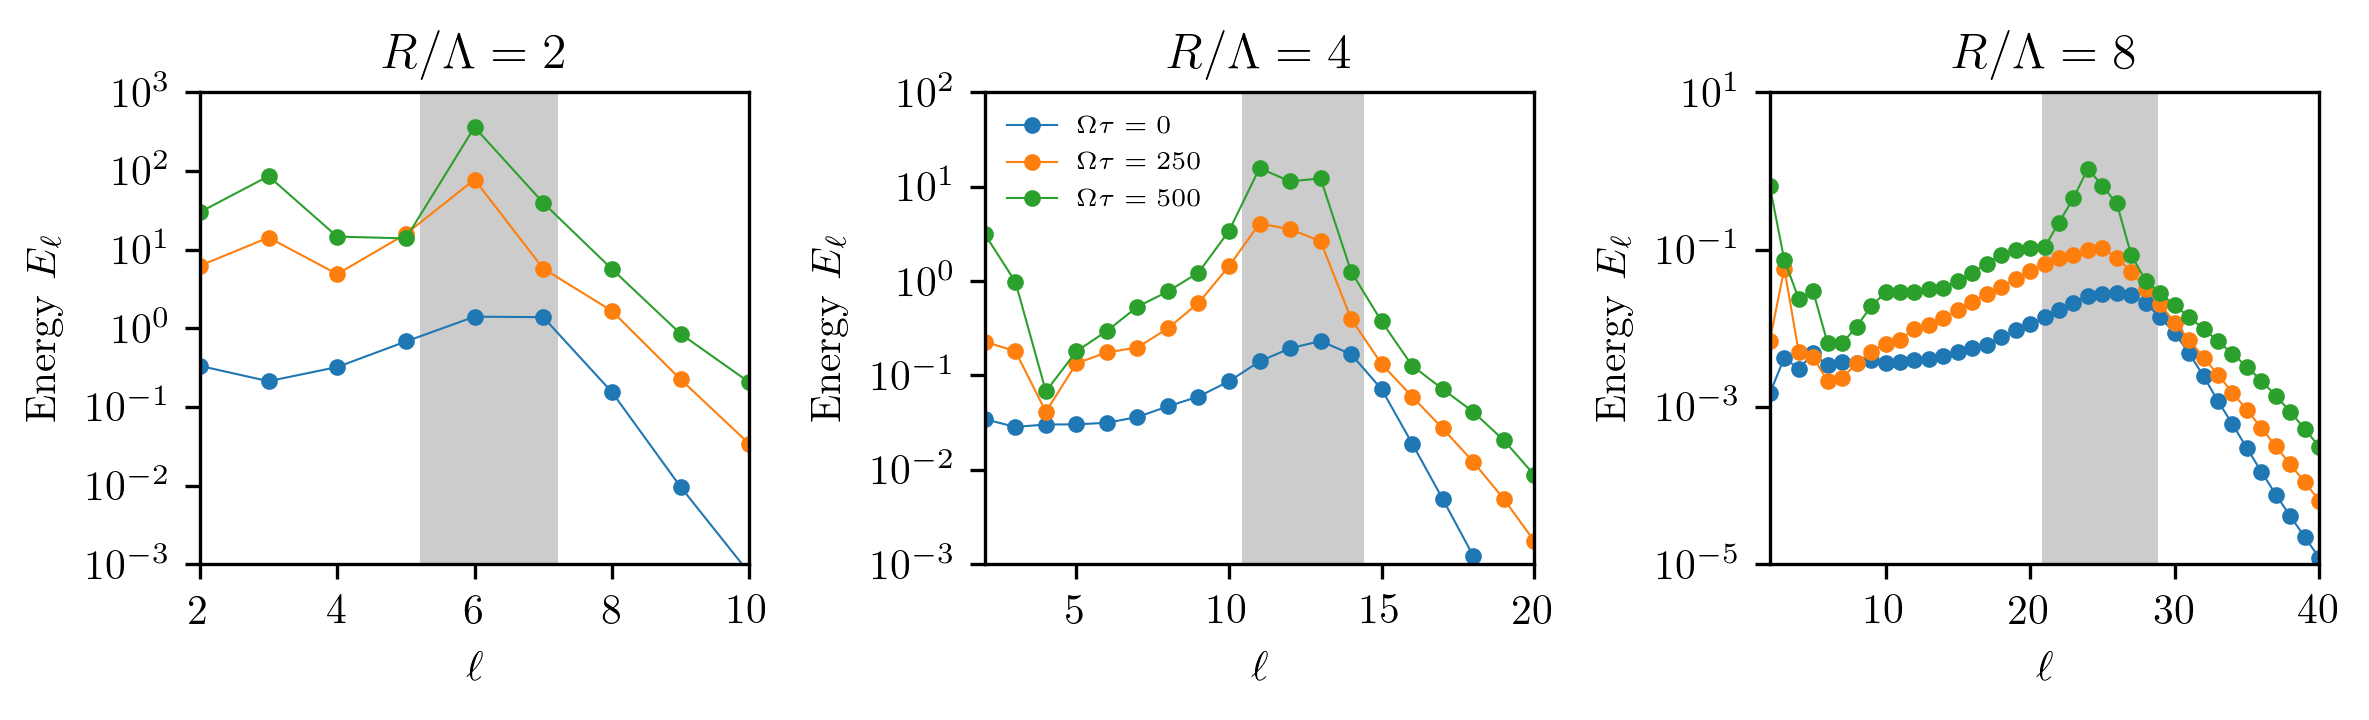

In [41]:
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman'], 'size': 10})
rc('text', usetex=True)


fig, ax = plt.subplots(1,3,figsize=(8,2.5), dpi=300)

lambdas = [2, 4, 8]
ell_max = [10, 20, 40]
ylims = [[10**-3, 10**3], [10**-3, 10**2], [10**-5, 10**1]]

for i in range(3):
    ell_m, ell_p = get_l(lambdas[i], 1)

    rect = Rectangle((ell_m, ylims[i][0]), ell_p - ell_m, ylims[i][1]-ylims[i][0], facecolor='k', alpha=0.2)
    ax[i].add_patch(rect)
    
    ax[i].set_title('$R/\Lambda = %i$' %(lambdas[i]))
    ax[i].set_ylabel('Energy $E_\ell$')
    ax[i].set_xlabel('$\ell$')
    ax[i].set_yscale('log')
    ax[i].minorticks_off()
    
    for j in range(0,3):
        
        ax[i].plot(ell[1:], E_ell[i][j][1:], '-o', markersize=3, linewidth=0.5)
        
        ax[i].set_xlim([2, ell_max[i]]);
        ax[i].set_ylim(ylims[i])
 
ax[1].legend(['$\Omega \\tau = 0$', '$\Omega \\tau = 250$', '$\Omega \\tau = 500$'], \
            frameon=False, loc='upper left', fontsize=6)
plt.tight_layout()
plt.savefig('../plots/fig4_raw.pdf')
        
    

In [46]:
E_ell[0][1][1:10]

array([3.32556860e-01, 2.12183227e-01, 3.21223254e-01, 6.78739283e-01,
       1.40471770e+00, 1.38388767e+00, 1.54419947e-01, 9.61425043e-03,
       7.70408810e-04])

In [49]:
E_ell[1][1][1:10]

array([3.32556860e-01, 2.12183227e-01, 3.21223254e-01, 6.78739283e-01,
       1.40471770e+00, 1.38388767e+00, 1.54419947e-01, 9.61425043e-03,
       7.70408810e-04])

In [236]:
hist = [None]*len(sphere_list)

ell = np.arange(1,256)
m = np.arange(0,256)

ellell, mm = np.meshgrid(ell, m)

for i in range(3):
    print(i)
    om_av = (np.abs(om_coeffs_ls[i][1500:, :, 1:])**2) / (ellell*(ellell+1))
    E_all = om_av.flatten()
    eps = 10**-5
    inds = np.where(E_all>eps)
    E_vals = E_all[inds]

    hist[i], edges = np.histogram(E_vals, bins=10000, density=True)
    E_mid = (edges[:-1] + edges[1:])/2

0
1
2


//anaconda3/envs/dedalus/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


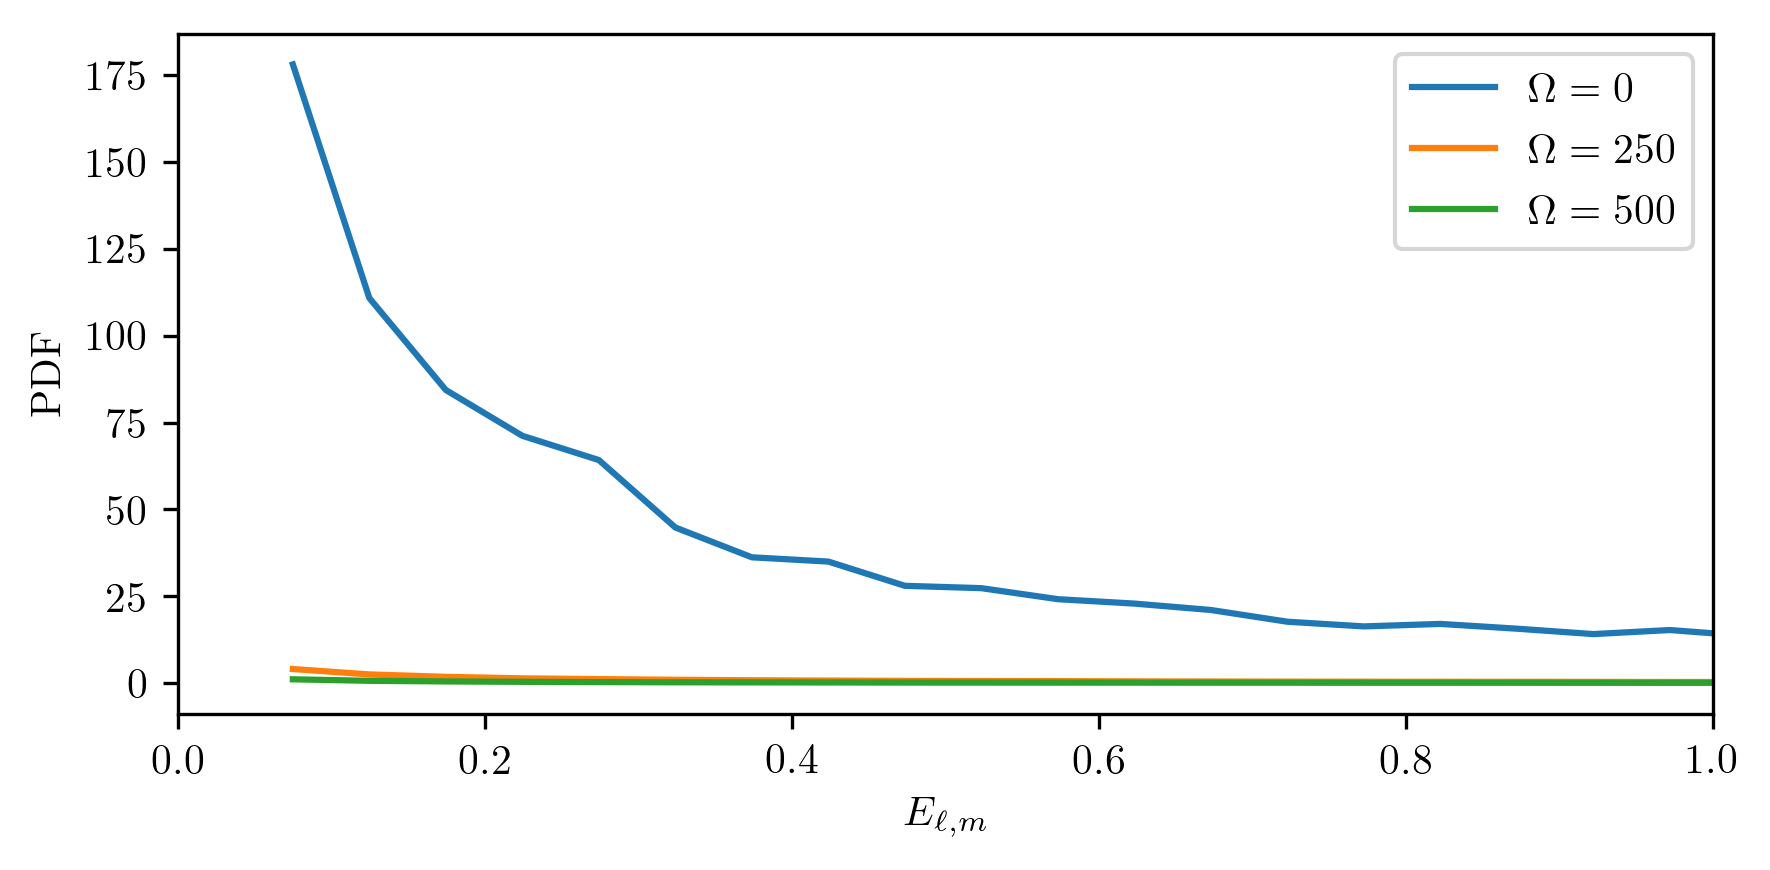

In [231]:
plt.figure(figsize=(6,3), dpi=300)
ax = plt.axes()

for i in range(3):
    plt.plot(E_mid[1:], hist[i][1:])
    #plt.plot(np.log10(E_mid[1:]), np.log10(hist[i][1:]))

ax.set_xlim([0, 1])
#plt.xscale('log')
#plt.yscale('log')

ax.legend(['$\Omega = 0$', '$\Omega = 250$', '$\Omega = 500$'])
plt.ylabel('PDF')
plt.xlabel('$E_{\ell, m}$')
#plt.xlim([0, 0.01]); 
#plt.ylim([1,10**5])

plt.tight_layout()
plt.savefig('../plots/E_pdf_Lmid=4.pdf')



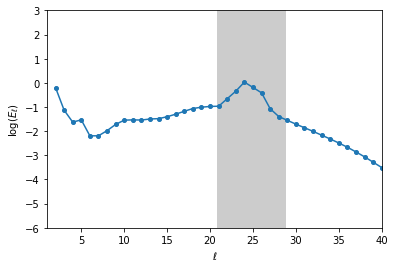

In [24]:
ax = plt.axes()
plt.plot(ell[1:], np.log10(E_ell_Om500[1:]), '-o', markersize=4)
plt.xlim([1,40]) 
plt.ylim([-6, 3])

plt.ylabel('$\log(E_\ell)$')
plt.xlabel('$\ell$')

ell_m, ell_p = get_l(8, 1)
rect = Rectangle((ell_m, -6), ell_p - ell_m, 9, facecolor='k', alpha=0.2)
ax.add_patch(rect)

//anaconda3/envs/dedalus/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


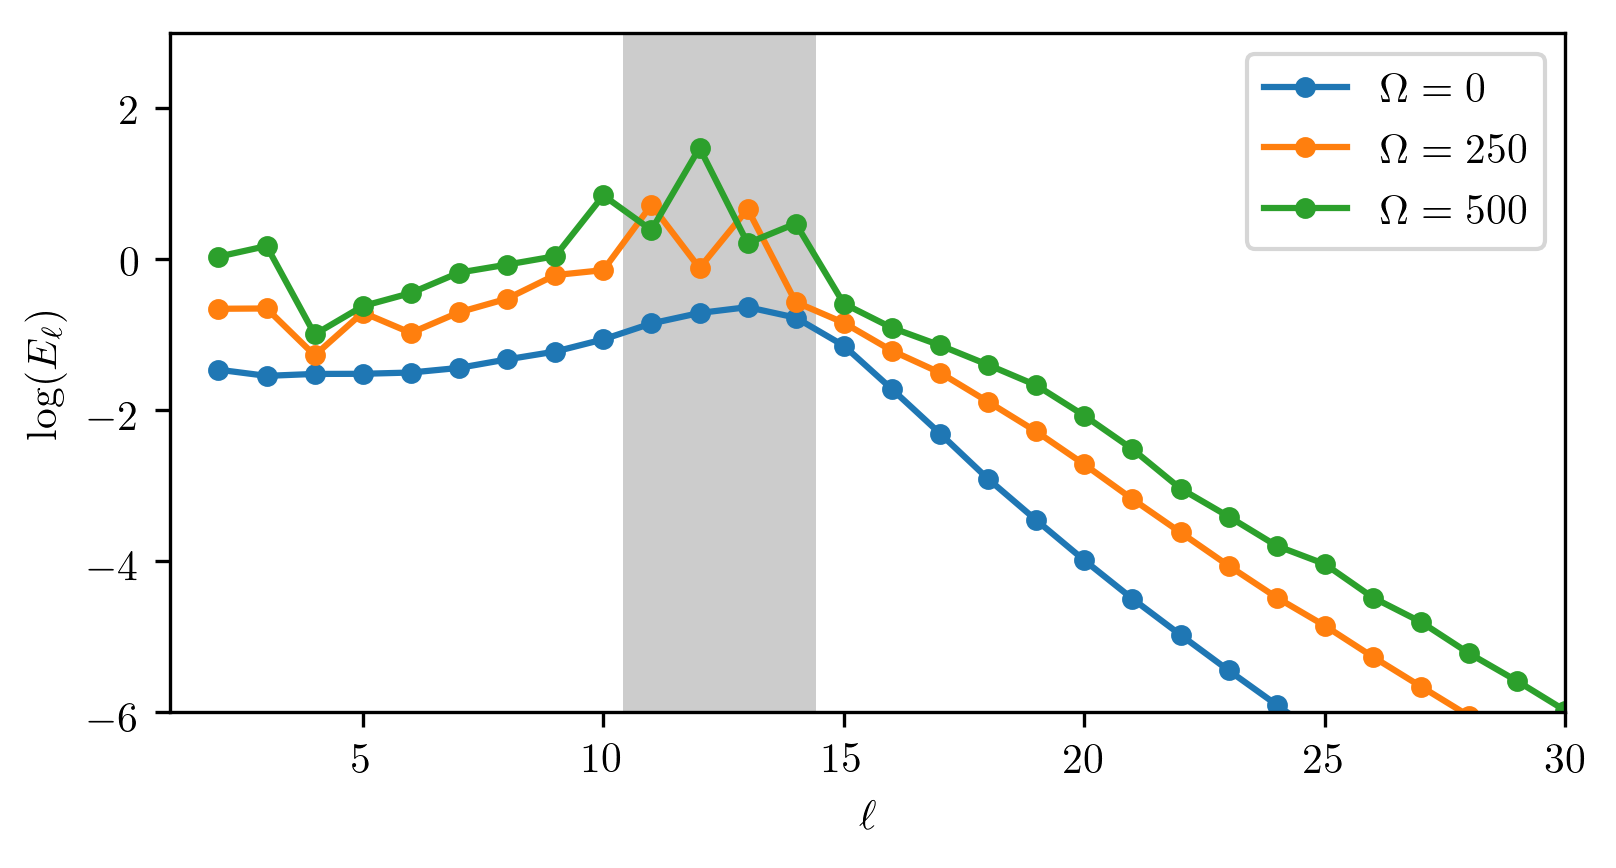

In [240]:
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman'], 'size': 10})
rc('text', usetex=True)

plt.figure(figsize=(6,3), dpi=300)
ax = plt.axes()

for i in range(3):
    ax.plot(ell[1:], np.log10(E_ell[i][1:]), '-o', markersize=4)
plt.xlim([1,30]) 
plt.ylim([-6, 3])

plt.ylabel('$\log(E_\ell)$')
plt.xlabel('$\ell$')

ell_m, ell_p = get_l(4, 1)

rect = Rectangle((ell_m, -6), ell_p - ell_m, 9, facecolor='k', alpha=0.2)
ax.add_patch(rect)

ax.legend(['$\Omega = 0$', '$\Omega = 250$', '$\Omega = 500$'])

plt.savefig('../plots/E_vs_ell_Lmid=4.pdf')

In [242]:
list(range(120,130))

[120, 121, 122, 123, 124, 125, 126, 127, 128, 129]

In [7]:
sphere_list

['sphere120',
 'sphere121',
 'sphere122',
 'sphere123',
 'sphere124',
 'sphere125',
 'sphere126',
 'sphere127',
 'sphere128',
 'sphere129']